In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, ConcatDataset

IMG_SIZE = 28
BATCH_SIZE = 10

# Transform for grayscale (1 channel)
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Only 1 channel
])


# Load train and test datasets
train_dataset = FashionMNIST(root='./data', train=True, download=False, transform=data_transforms)
test_dataset = FashionMNIST(root='./data', train=False, download=False, transform=data_transforms)

# Combine them
full_dataset = ConcatDataset([train_dataset, test_dataset])


# Example: total number of samples
print(f"Total samples: {len(full_dataset)}")  # Should be 60000 + 10000 = 70000


c:\Users\SABA\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total samples: 70000


In [2]:

dataloader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=2,
                        drop_last=True,
                        pin_memory=True,
                        prefetch_factor=6)

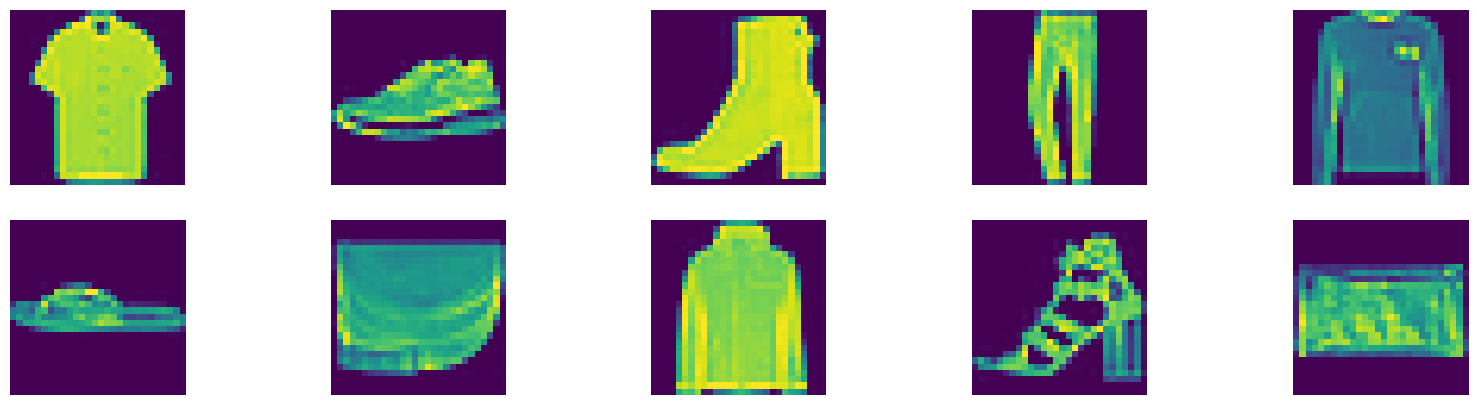

In [3]:
import matplotlib.pyplot as plt
i =0
n = 5
plt.figure(figsize=(20,5))
for images,_ in dataloader:
   for i in range(10):
     normalized_image = (images[i] - images[i].min()) / (images[i].max() - images[i].min())
     image = normalized_image.permute(1, 2, 0)
     plt.subplot(2, n, i + 1)
     plt.imshow(image)
     plt.axis('off')
   plt.show()
   break

In [ ]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import logging
from torch.utils.tensorboard import SummaryWriter


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=0.0001, beta_end=0.02, img_size=28, device="cuda"): #beta = (0.0001,0.02)
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0,total=999):
                t = (torch.ones(n) * i).long().to(self.device)
                ##Prediction of noise from Unet
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    #Denoise
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Crop  spatially to match target shape from center.
def crop_to_match(source, target):
    
    _, _, h_s, w_s = source.shape
    _, _, h_t, w_t = target.shape

    dh = h_s - h_t
    dw = w_s - w_t

    crop_top = dh // 2
    crop_left = dw // 2

    return source[:, :, crop_top:crop_top + h_t, crop_left:crop_left + w_t]



class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)  # head=4
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        # x shape: (batch, channels, size, size)
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)  # (batch, size*size, channels)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

###Doesnt change dimensions
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            ##Ceil mode for dimension  for e.g: 7/2=3.5 ,with ceil_mode=4
            nn.MaxPool2d(2, ceil_mode=True),  
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        
        # dimension consistancy of skip and x
        if x.shape[-2:] != skip_x.shape[-2:]:
            x = F.interpolate(x, size=skip_x.shape[-2:], mode="bilinear", align_corners=True)
        
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb



class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim

        self.inc = DoubleConv(c_in, 64)       # 28x28 -> 28x28
        self.down1 = Down(64, 128)            # 28x28 -> 14x14
        self.sa1 = SelfAttention(128, 14)     # self attention on 14

        self.down2 = Down(128, 256)           # 14x14 -> 7x7
        
        self.down3 = Down(256, 256)           # 7x7 -> 4x4 

        self.bot1 = DoubleConv(256, 512)      
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)                # 4x4 -> 7x7
    

        self.up2 = Up(256, 64)                 # 7x7 -> 14x14
        # self attention on 14 in Up
        self.sa5 = SelfAttention(64, 14)      

        self.up3 = Up(128, 64)                 # 14x14 -> 28x28

        self.outc = nn.Conv2d(64, c_out, kernel_size=1)  # 28x28
    #Positional encoding
    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)          # 28x28
        x2 = self.down1(x1, t)   # 14x14
        x2 = self.sa1(x2)        # SelfAttention on 14x14

        x3 = self.down2(x2, t)   # 7x7

        x4 = self.down3(x3, t)   # 4x4

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)  # 4x4 -> 7x7
  

        x = self.up2(x, x2, t)   # 7x7 -> 14x14
        x = self.sa5(x)          # SelfAttention on 14x14

        x = self.up3(x, x1, t)   # 14x14 -> 28x28

        output = self.outc(x)    # output
        return output


In [10]:
import os
import torchvision
from PIL import Image

def plot_images(images):
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    images = (images - images.min()) / (images.max() - images.min())
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def save_images(images, path, **kwargs):

    os.makedirs(os.path.dirname(path), exist_ok=True)
    images = (images - images.min()) / (images.max() - images.min())
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    ndarr = (ndarr * 255).clip(0, 255).astype('uint8')
    im = Image.fromarray(ndarr)
    im.save(path)

In [11]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
class Args:
    epochs = 100
    device = "cuda" if torch.cuda.is_available() else "cpu"
    lr = 1e-4

args = Args()
epoch =0
img_size = 28
device = args.device
unet=UNet().to(device)
optimizer = optim.AdamW(unet.parameters(), lr=args.lr)
Loss = nn.MSELoss()
diffusion = Diffusion(img_size=img_size, device=device)

In [12]:
total_params = sum(p.numel() for p in unet.parameters())
print(total_params)
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-5

22415105


100%|██████████| 7000/7000 [11:14<00:00, 10.38it/s, Epoch=1, loss=0.0408] 


Epoch:1 | Ep Av Loss:0.082256


100%|██████████| 7000/7000 [11:36<00:00, 10.04it/s, Epoch=2, loss=0.0341] 


Epoch:2 | Ep Av Loss:0.053080


100%|██████████| 7000/7000 [11:47<00:00,  9.89it/s, Epoch=3, loss=0.0341] 


Epoch:3 | Ep Av Loss:0.048466


100%|██████████| 7000/7000 [11:28<00:00, 10.16it/s, Epoch=4, loss=0.105]  


Epoch:4 | Ep Av Loss:0.046299


100%|██████████| 7000/7000 [11:06<00:00, 10.50it/s, Epoch=5, loss=0.0555] 


Epoch:5 | Ep Av Loss:0.044739


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=6, loss=0.0237] 


Epoch:6 | Ep Av Loss:0.043644


100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=7, loss=0.00764]


Epoch:7 | Ep Av Loss:0.043064


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=8, loss=0.0431] 


Epoch:8 | Ep Av Loss:0.041690


100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=9, loss=0.074]  


Epoch:9 | Ep Av Loss:0.041624


100%|██████████| 7000/7000 [11:46<00:00,  9.91it/s, Epoch=10, loss=0.0705] 


Epoch:10 | Ep Av Loss:0.040617


100%|██████████| 999/999 [00:23<00:00, 43.31it/s]


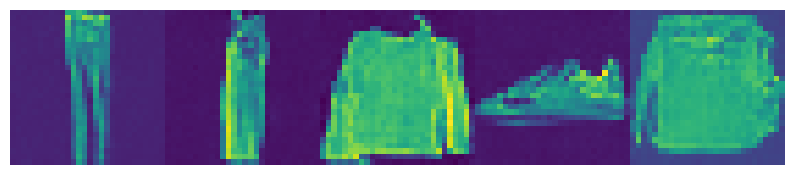

100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=11, loss=0.0169] 


Epoch:11 | Ep Av Loss:0.040366


100%|██████████| 7000/7000 [10:49<00:00, 10.78it/s, Epoch=12, loss=0.027]  


Epoch:12 | Ep Av Loss:0.040960


100%|██████████| 7000/7000 [11:01<00:00, 10.58it/s, Epoch=13, loss=0.016]  


Epoch:13 | Ep Av Loss:0.040296


100%|██████████| 7000/7000 [11:08<00:00, 10.47it/s, Epoch=14, loss=0.0276] 


Epoch:14 | Ep Av Loss:0.039922


100%|██████████| 7000/7000 [11:15<00:00, 10.37it/s, Epoch=15, loss=0.0236] 


Epoch:15 | Ep Av Loss:0.039462


100%|██████████| 7000/7000 [11:40<00:00,  9.99it/s, Epoch=16, loss=0.0325] 


Epoch:16 | Ep Av Loss:0.039200


100%|██████████| 7000/7000 [11:29<00:00, 10.15it/s, Epoch=17, loss=0.0518] 


Epoch:17 | Ep Av Loss:0.038966


100%|██████████| 7000/7000 [11:33<00:00, 10.10it/s, Epoch=18, loss=0.0362] 


Epoch:18 | Ep Av Loss:0.038788


100%|██████████| 7000/7000 [11:45<00:00,  9.93it/s, Epoch=19, loss=0.0355] 


Epoch:19 | Ep Av Loss:0.038600


100%|██████████| 7000/7000 [11:53<00:00,  9.81it/s, Epoch=20, loss=0.0178]  


Epoch:20 | Ep Av Loss:0.038757


100%|██████████| 999/999 [00:24<00:00, 40.20it/s]


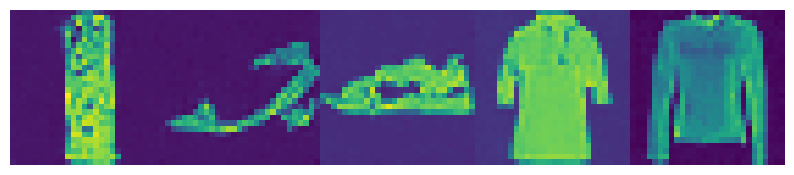

100%|██████████| 7000/7000 [11:50<00:00,  9.85it/s, Epoch=21, loss=0.0458] 


Epoch:21 | Ep Av Loss:0.038947


100%|██████████| 7000/7000 [11:49<00:00,  9.86it/s, Epoch=22, loss=0.0573] 


Epoch:22 | Ep Av Loss:0.038718


100%|██████████| 7000/7000 [1:10:05<00:00,  1.66it/s, Epoch=23, loss=0.03]        


Epoch:23 | Ep Av Loss:0.037791


100%|██████████| 7000/7000 [10:49<00:00, 10.78it/s, Epoch=24, loss=0.0348] 


Epoch:24 | Ep Av Loss:0.037796


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=25, loss=0.0313] 


Epoch:25 | Ep Av Loss:0.038094


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=26, loss=0.0233] 


Epoch:26 | Ep Av Loss:0.037666


100%|██████████| 7000/7000 [10:54<00:00, 10.69it/s, Epoch=27, loss=0.0157] 


Epoch:27 | Ep Av Loss:0.037479


100%|██████████| 7000/7000 [10:54<00:00, 10.70it/s, Epoch=28, loss=0.045]  


Epoch:28 | Ep Av Loss:0.037388


100%|██████████| 7000/7000 [10:55<00:00, 10.69it/s, Epoch=29, loss=0.0312] 


Epoch:29 | Ep Av Loss:0.037922


100%|██████████| 7000/7000 [10:54<00:00, 10.69it/s, Epoch=30, loss=0.0317] 


Epoch:30 | Ep Av Loss:0.037166


100%|██████████| 999/999 [00:23<00:00, 42.94it/s]


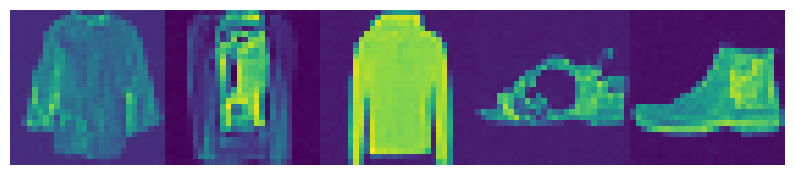

100%|██████████| 7000/7000 [10:56<00:00, 10.67it/s, Epoch=31, loss=0.02]   


Epoch:31 | Ep Av Loss:0.037103


100%|██████████| 7000/7000 [10:55<00:00, 10.69it/s, Epoch=32, loss=0.0153] 


Epoch:32 | Ep Av Loss:0.037209


100%|██████████| 7000/7000 [10:55<00:00, 10.68it/s, Epoch=33, loss=0.0077] 


Epoch:33 | Ep Av Loss:0.036902


100%|██████████| 7000/7000 [10:55<00:00, 10.69it/s, Epoch=34, loss=0.0192] 


Epoch:34 | Ep Av Loss:0.036763


100%|██████████| 7000/7000 [10:56<00:00, 10.66it/s, Epoch=35, loss=0.0203] 


Epoch:35 | Ep Av Loss:0.037203


100%|██████████| 7000/7000 [10:56<00:00, 10.67it/s, Epoch=36, loss=0.031]  


Epoch:36 | Ep Av Loss:0.036980


100%|██████████| 7000/7000 [10:54<00:00, 10.70it/s, Epoch=37, loss=0.0517] 


Epoch:37 | Ep Av Loss:0.036624


100%|██████████| 7000/7000 [11:08<00:00, 10.47it/s, Epoch=38, loss=0.0399] 


Epoch:38 | Ep Av Loss:0.036769


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=39, loss=0.0192] 


Epoch:39 | Ep Av Loss:0.036610


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=40, loss=0.0108] 


Epoch:40 | Ep Av Loss:0.036770


100%|██████████| 999/999 [00:22<00:00, 43.93it/s]


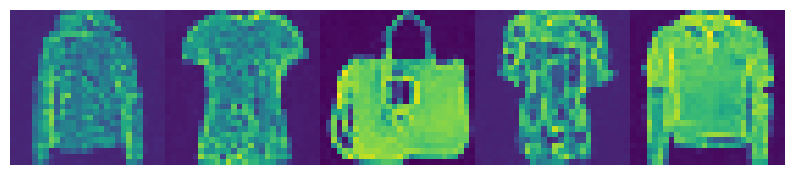

100%|██████████| 7000/7000 [11:13<00:00, 10.39it/s, Epoch=41, loss=0.00377]


Epoch:41 | Ep Av Loss:0.036397


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=42, loss=0.0253] 


Epoch:42 | Ep Av Loss:0.035872


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=43, loss=0.019]  


Epoch:43 | Ep Av Loss:0.036481


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=44, loss=0.0255] 


Epoch:44 | Ep Av Loss:0.036419


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=45, loss=0.0276] 


Epoch:45 | Ep Av Loss:0.036312


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=46, loss=0.0239] 


Epoch:46 | Ep Av Loss:0.036118


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=47, loss=0.0609] 


Epoch:47 | Ep Av Loss:0.036229


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=48, loss=0.0604] 


Epoch:48 | Ep Av Loss:0.036358


100%|██████████| 7000/7000 [10:52<00:00, 10.72it/s, Epoch=49, loss=0.0097] 


Epoch:49 | Ep Av Loss:0.036211


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=50, loss=0.021]  


Epoch:50 | Ep Av Loss:0.035759


100%|██████████| 999/999 [00:22<00:00, 43.65it/s]


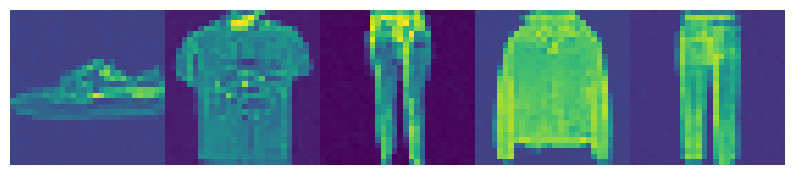

100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=51, loss=0.0315] 


Epoch:51 | Ep Av Loss:0.036314


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=52, loss=0.0265] 


Epoch:52 | Ep Av Loss:0.035846


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=53, loss=0.0201] 


Epoch:53 | Ep Av Loss:0.035611


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=54, loss=0.0831] 


Epoch:54 | Ep Av Loss:0.036377


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=55, loss=0.016]  


Epoch:55 | Ep Av Loss:0.035869


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=56, loss=0.0825] 


Epoch:56 | Ep Av Loss:0.035858


100%|██████████| 7000/7000 [10:53<00:00, 10.72it/s, Epoch=57, loss=0.0413] 


Epoch:57 | Ep Av Loss:0.035541


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=58, loss=0.102]  


Epoch:58 | Ep Av Loss:0.035544


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=59, loss=0.0344] 


Epoch:59 | Ep Av Loss:0.035850


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=60, loss=0.0118] 


Epoch:60 | Ep Av Loss:0.035826


100%|██████████| 999/999 [00:22<00:00, 44.23it/s]


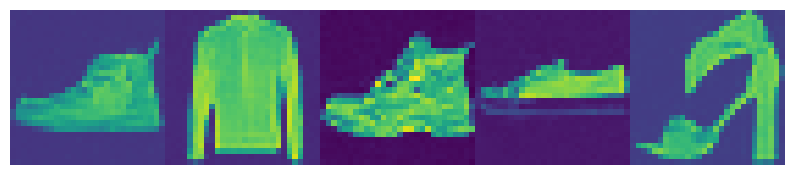

100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=61, loss=0.0232] 


Epoch:61 | Ep Av Loss:0.035576


100%|██████████| 7000/7000 [10:49<00:00, 10.78it/s, Epoch=62, loss=0.0329] 


Epoch:62 | Ep Av Loss:0.035055


100%|██████████| 7000/7000 [10:52<00:00, 10.73it/s, Epoch=63, loss=0.046]  


Epoch:63 | Ep Av Loss:0.035759


100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=64, loss=0.0185] 


Epoch:64 | Ep Av Loss:0.035435


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=65, loss=0.0552] 


Epoch:65 | Ep Av Loss:0.035266


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=66, loss=0.0743] 


Epoch:66 | Ep Av Loss:0.035094


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=67, loss=0.0415] 


Epoch:67 | Ep Av Loss:0.035361


100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=68, loss=0.0181] 


Epoch:68 | Ep Av Loss:0.035468


100%|██████████| 7000/7000 [10:50<00:00, 10.75it/s, Epoch=69, loss=0.0858] 


Epoch:69 | Ep Av Loss:0.035533


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=70, loss=0.0473] 


Epoch:70 | Ep Av Loss:0.035026


100%|██████████| 999/999 [00:22<00:00, 43.44it/s]


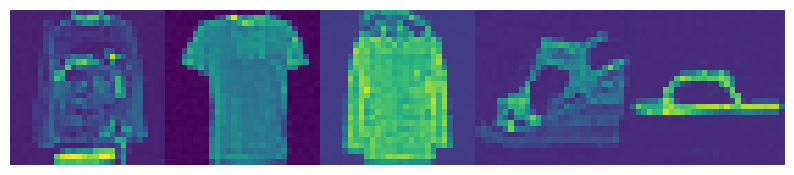

100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=71, loss=0.0445] 


Epoch:71 | Ep Av Loss:0.035263


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=72, loss=0.0537] 


Epoch:72 | Ep Av Loss:0.034856


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=73, loss=0.031]  


Epoch:73 | Ep Av Loss:0.035398


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=74, loss=0.0293] 


Epoch:74 | Ep Av Loss:0.035083


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=75, loss=0.0204] 


Epoch:75 | Ep Av Loss:0.034698


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=76, loss=0.0566] 


Epoch:76 | Ep Av Loss:0.035311


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=77, loss=0.0316] 


Epoch:77 | Ep Av Loss:0.035089


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=78, loss=0.0153] 


Epoch:78 | Ep Av Loss:0.035242


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=79, loss=0.0673] 


Epoch:79 | Ep Av Loss:0.034857


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=80, loss=0.0532] 


Epoch:80 | Ep Av Loss:0.035102


100%|██████████| 999/999 [00:23<00:00, 43.09it/s]


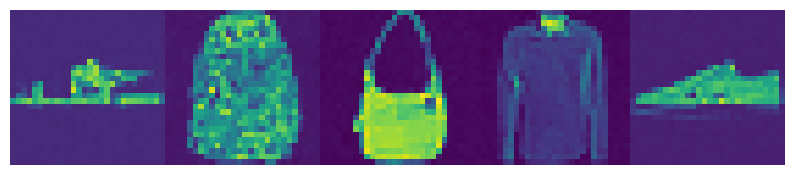

100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=81, loss=0.0343] 


Epoch:81 | Ep Av Loss:0.035203


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=82, loss=0.0411] 


Epoch:82 | Ep Av Loss:0.034828


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=83, loss=0.0173] 


Epoch:83 | Ep Av Loss:0.035302


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=84, loss=0.0371] 


Epoch:84 | Ep Av Loss:0.034771


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=85, loss=0.0211] 


Epoch:85 | Ep Av Loss:0.034834


100%|██████████| 7000/7000 [10:51<00:00, 10.74it/s, Epoch=86, loss=0.059]  


Epoch:86 | Ep Av Loss:0.034447


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=87, loss=0.0247] 


Epoch:87 | Ep Av Loss:0.034369


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=88, loss=0.0144] 


Epoch:88 | Ep Av Loss:0.034868


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=89, loss=0.0161] 


Epoch:89 | Ep Av Loss:0.034659


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=90, loss=0.0521] 


Epoch:90 | Ep Av Loss:0.034988


100%|██████████| 999/999 [00:22<00:00, 43.71it/s]


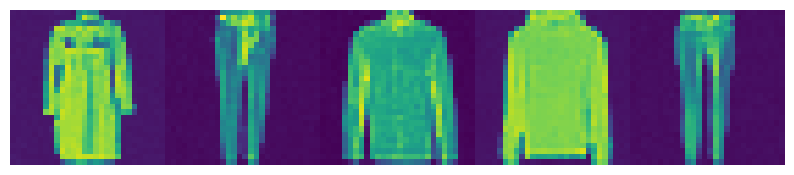

100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=91, loss=0.0303] 


Epoch:91 | Ep Av Loss:0.034500


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=92, loss=0.0546] 


Epoch:92 | Ep Av Loss:0.034768


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=93, loss=0.106]  


Epoch:93 | Ep Av Loss:0.035043


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=94, loss=0.02]   


Epoch:94 | Ep Av Loss:0.034361


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=95, loss=0.0195] 


Epoch:95 | Ep Av Loss:0.034890


100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=96, loss=0.00329]


Epoch:96 | Ep Av Loss:0.034724


100%|██████████| 7000/7000 [10:51<00:00, 10.75it/s, Epoch=97, loss=0.0502] 


Epoch:97 | Ep Av Loss:0.035015


100%|██████████| 7000/7000 [10:49<00:00, 10.77it/s, Epoch=98, loss=0.0332] 


Epoch:98 | Ep Av Loss:0.034398


100%|██████████| 7000/7000 [10:50<00:00, 10.77it/s, Epoch=99, loss=0.0461] 


Epoch:99 | Ep Av Loss:0.034552


100%|██████████| 7000/7000 [10:50<00:00, 10.76it/s, Epoch=100, loss=0.0327] 


Epoch:100 | Ep Av Loss:0.034601


100%|██████████| 999/999 [00:22<00:00, 43.83it/s]


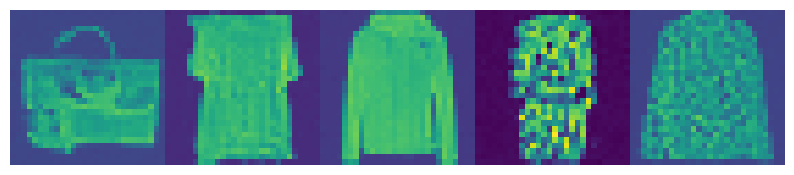

In [13]:
# Training loop
epoch = 0
while epoch < args.epochs:
    epoch += 1
    pbar = tqdm(dataloader)
    Sl = 0
    EAL = 0
    N = 0

    for i, (images, _) in enumerate(pbar):
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        images = images.to(device)
        x_t, noise = diffusion.noise_images(images, t)
        predicted_noise = unet(x_t, t)
        loss = Loss(noise, predicted_noise)

        Sl += loss.item()
        N += 1
        EAL = Sl / N

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(Epoch=epoch, loss=loss.item())

    # Ensure directory exists
    os.makedirs("model", exist_ok=True)
    unet_path = os.path.join("model", "unet.pth")

    checkpoint = {
        'epoch': epoch,
        'unet_state_dict': unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, unet_path)
    print(f"Epoch:{epoch} | Ep Av Loss:{EAL:.6f}")

    # Show , save 5 images every 10 epochs
    if epoch % 10 == 0:
        sampled_image = diffusion.sample(unet, n=5)
        plot_images(sampled_image)
        save_images(sampled_image, os.path.join("model", f"{epoch}.jpg"))